In [4]:
import os
import json

import tiktoken
from collections import Counter
import random
from datasets import Dataset, IterableDataset, load_from_disk
import pickle
import numpy as np
from phonenumbers import PhoneNumberMatcher
import multiprocess as mp
from collections import defaultdict
import nltk
import matplotlib.pyplot as plt
import numpy as np
import shutil
from nltk.tokenize import sent_tokenize
import sys
import gc
from datasketch import MinHash, MinHashLSH
import unicodedata
import re

sys.path.append('../scripts')
from utils import *
import detect_en
import mask_pii
import gopher_filter
import dedup


In [2]:
ds_name = 'big-5p'
ds_path = '../data/'+ds_name

In [11]:
ds.save_to_disk(ds_path+'-new')
shutil.rmtree(ds_path)
os.rename(ds_path+'-new', ds_path)

Saving the dataset (0/11 shards):   0%|          | 0/199332 [00:00<?, ? examples/s]

In [5]:
ds = load_from_disk(ds_path)
ds

Dataset({
    features: ['text', 'url', 'en_proba', 'erased_mail', 'n_erased_mail', 'erased_phone', 'n_erased_phone', 'gopher_verdict', 'sentences', 'sentences_normalized', 'dedup_text', 'erased_dedup', 'dedup_diff', 'id', 'dedup_sentences', 'dedup_sentences_normalized'],
    num_rows: 199332
})

In [6]:
q='the presunrise to sunset.fast lasts anywhere from 12 to 18 hours depending on where in the world you are<SEP>al jazeera by mohammed haddad published on 20 mar 2023 20 mar 2023 the muslim holy month of ramadan will begin on thursday<SEP>the presunrise to sunset fast lasts anywhere from 12 to 18 hours depending on where you are in the world'
w='the presunrise to sunset fast lasts anywhere from 12 to 18 hours depending on where in the world you are<SEP>al jazeera by mohammed haddad published on 20 mar 2023 20 mar the muslim holy month of ramadan will begin later this week<SEP>the presunrise to sunset fast lasts anywhere from 12 to 18 hours depending on where you are in the world'
q!=w

data = [
    "This agreement is between John Doe and the Company. By using our service, you agree to the terms.",
    "This agreement is between Jane Smith and the Company. By using our service, you agree to the terms.",
    "This agreement is between The Client and the Company. By using our service, you agree to the terms.",
    "This document covers unrelated topics."
]
data = [
    q,
    w,
    "A fast brown fox leaps over a sleepy dog",
    "Completely unrelated sentence"
]

In [7]:
NUM_PERM=128
N_GRAMS=3
JACCARD_THRESHOLD=0.7

lsh = MinHashLSH(threshold=JACCARD_THRESHOLD, num_perm=NUM_PERM)
minhashes = {}

for i, text in enumerate(data):
    normalized_text = normalize_for_hashing(text)
    m = create_minhash(normalized_text, num_perm=NUM_PERM, num_words_n_gram=N_GRAMS)
    lsh.insert(f"doc_{i}", m)
    minhashes[f"doc_{i}"] = m

for i, m in minhashes.items():
    result = lsh.query(m)
    print(f"{i} is similar to: {result}")

doc_0 is similar to: ['doc_1', 'doc_0']
doc_1 is similar to: ['doc_1', 'doc_0']
doc_2 is similar to: ['doc_2']
doc_3 is similar to: ['doc_3']


In [10]:
new_mapping = { 'text_field':'dedup_text',
                'sentences_field':'dedup_sentences',
                'sentences_normalized_field':'dedup_sentences_normalized' }

ds = ds.map(apply_normalization, batched=True, num_proc=4, fn_kwargs=new_mapping)

Map (num_proc=4):   0%|          | 0/199332 [00:00<?, ? examples/s]

In [173]:
l=np.array([len(x) for x in ds['text']])
l   

array([17430, 22642, 14792, ...,   538,  5204, 11334])

In [175]:
l.mean()

np.float64(3764.8779072100815)

In [ ]:
n=normalize_for_hashing(ds[0]['text'])
print(n)

In [1]:
import fasttext
model = fasttext.load_model("model_filename_3gram.bin")


In [6]:
def quality_score(examples):
    qualities = []
    for t in examples['text']:
        nt = normalize_for_hashing(t)
        l,p = model.predict(nt)
        proba = p[0].item()
        label = l[0]
        if label == '__label__neg':
            quality = 1.0-proba
        else:
            quality = proba
        qualities.append(quality)
    examples['quality']=qualities
    return examples

ds=ds.map(quality_score,batched=True)

Parameter 'function'=<function quality_score at 0x39cb37dc0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/199332 [00:00<?, ? examples/s]

In [7]:
ds

Dataset({
    features: ['text', 'url', 'en_proba', 'erased_mail', 'n_erased_mail', 'erased_phone', 'n_erased_phone', 'gopher_verdict', 'sentences', 'sentences_normalized', 'dedup_text', 'erased_dedup', 'dedup_diff', 'id', 'dedup_sentences', 'dedup_sentences_normalized', 'quality'],
    num_rows: 199332
})

In [8]:
ds['quality'][0]

0.2372962236404419

In [9]:
qs=np.array(ds['quality'])

In [10]:
qs.mean()

np.float64(0.024771788410775587)

In [15]:
qs.std()

np.float64(0.07379269053026961)

In [85]:
idx = np.where(qs<0.0000000001)[0].tolist()
len(idx)

19463

In [104]:
count = 0
for i in range(len(ds)):
    t = ds[i]['erased_dedup']
    if len(t):
        print(t)
        count+=1
        if count>200:
            break

>>Sign Up For Free To finish signing up, check your inbox for a link to confirm your email address.Sorry, something went wrong.Please try again.
>>More Must-Read Stories From TIME
>>Listen to this story.Enjoy more audio and podcasts on iOS or Android .Your browser does not support the <audio> element.
>>The
>>More Must-Read Stories From TIME
>>More Must-Read Stories From TIME
>>Listen to this story.Enjoy more audio and podcasts on iOS or Android .Your browser does not support the <audio> element.
>>Readers get an in-depth look at how the next wave of tech will reshape civic and political life, including activism, fundraising, lobbying and legislating.Go inside the minds of the biggest tech players, policymakers and regulators to learn how their decisions affect our lives.Don't miss out, subscribe today .
>>STEP INSIDE THE WEST WING : What's really happening in West Wing offices?Find out who's up, who's down, and who really has the president’s ear in our West Wing Playbook newsletter, t

In [92]:
i = idx[17000]
print(ds[i]['quality'])
print(ds[i]['text'][:1000])

-7.271766662597656e-06
View more
EVENTS AND PARTNERSHIPS EXECUTIVE (HIGH VALUE FUNDRAISING EVENTS)
Salary: From £24,550 per annum pro rata + benefits
Location: Stratford (high flex - we would expect you to be in the office 1-2 days per week).
Contract Length: Fixed-term until end of March 2023
Hours per week: 35
Closing date: Sunday 7th August 2022, 23:55*
* Please note that we may close this role earlier than stated, therefore early application is encouraged to avoid disappointment.
Do you have a passion for working in events and are looking for a new challenge working with the world's leading independent cancer charity? If so, this could the ideal opportunity for you to join our high value fundraising events team.
Why we need you
The High Value Fundraising Events team manage high-value fundraising partnerships with committees, individuals and organisations to deliver an inspiring portfolio of circa. 10 special events each year, each with income between £100k - £1m.
We're looking for 

In [28]:
idx=np.where(np.array(ds['gopher_verdict'])!='ok')[0].tolist()

In [33]:
np.array([ds[i]['quality'] for i in idx]).mean()

np.float64(0.012854086512575136)

In [54]:
len(idx)

138312

In [217]:
magic = qs.mean()-qs.std()

In [218]:
(qs<magic).sum()

np.int64(0)

In [201]:

nt = normalize_for_hashing(ds['text'][0])
l,p = model.predict(nt)
proba = p[0].item()
label = l[0]
label, proba

('__label__neg', 0.8799633979797363)

In [203]:
np.where(qs<0.1

(array([], dtype=int64),)

In [181]:
l,p=model.predict(n)


('__label__neg', 0.8799633979797363)

In [176]:
ds

Dataset({
    features: ['text', 'url', 'en_proba', 'erased_mail', 'n_erased_mail', 'erased_phone', 'n_erased_phone', 'gopher_verdict', 'sentences', 'sentences_normalized', 'dedup_text', 'erased_dedup', 'dedup_diff', 'id', 'dedup_sentences', 'dedup_sentences_normalized'],
    num_rows: 199332
})

In [14]:
def calculate_sentences_minhashes(examples, minhashes_sentence_field='dedup_sentences_normalized'):
    entry_hashes = []
    for entry_id, sentences in zip(examples['id'], examples[minhashes_sentence_field]):
        sts_grouped = generate_3grams_sentences_groups(sentences)
        sentence_hashes = []
        for sts_id, sts_group in enumerate(sts_grouped):
            text = ' '.join([s.replace('<PAD>', '') for s in sts_group])
            minhash = create_minhash(text, num_perm=NUM_PERM, num_words_n_gram=N_GRAMS)
            sts_key = str(entry_id)+'-'+str(sts_id)
            sentence_hashes.append(pickle.dumps(minhash))
        entry_hashes.append(sentence_hashes)
    examples['sentences_hashes']=entry_hashes
    return examples

hs=ds.shuffle(22).select(range(len(ds)//20)).map(calculate_sentences_minhashes,batched=True)

Map:   0%|          | 0/9966 [00:00<?, ? examples/s]

In [17]:
lsh = MinHashLSH(threshold=JACCARD_THRESHOLD, num_perm=NUM_PERM)
minhashes = {}

for x in tqdm(hs):
    for sid, h in enumerate(x['sentences_hashes']):
        sts_key = str(x['id'])+'-'+str(sid)
        m = pickle.loads(h)
        lsh.insert(sts_key, m)
        minhashes[sts_key]=m

100%|██████████████████████████████████████| 9966/9966 [00:06<00:00, 1595.96it/s]


In [18]:
ds

Dataset({
    features: ['text', 'url', 'en_proba', 'erased_mail', 'n_erased_mail', 'erased_phone', 'n_erased_phone', 'gopher_verdict', 'sentences', 'sentences_normalized', 'dedup_text', 'erased_dedup', 'dedup_diff', 'id', 'dedup_sentences', 'dedup_sentences_normalized'],
    num_rows: 199332
})

In [44]:

nhs=hs.map(erase_duplicates,batched=True)

Map:   0%|          | 0/9966 [00:00<?, ? examples/s]

In [49]:
sum(len(x) for x in nhs['dedup_lsh_text'])*100/sum(len(x) for x in nhs['dedup_text'])

98.99036108468103

In [59]:
sum(1 for x in nhs['dedup_lsh_text'] if len(x.strip())==0)*100/len(nhs)

2.508528998595224

In [61]:
sum(1 for x in nhs if x['dedup_lsh_text']!=x['dedup_text'])*100/len(nhs)

3.7928958458759783

In [62]:
for x in nhs.shuffle(50):
    if x['dedup_lsh_text']!=x['dedup_text']:
        break
print(x['url'])
print(x['dedup_lsh_diff'])
print('========')
x['dedup_lsh_text'].strip()

https://www.theage.com.au/national/victoria/family-pleads-for-more-help-in-locating-melbourne-man-as-quake-search-enters-fifth-day-20230210-p5cjja.html?ref=rss&amp;utm_medium=rss&amp;utm_source=rss_national
The daughter of a Melbourne man who is missing in Turkey following the region’s devastating earthquakes has pleaded for more help to find her father as the search enters its fifth day. Coburg woman Imren Bayram is still desperate to find her missing father Suat , who was in Kirikhan in the Turkish region of Hatay when the disaster occurred. Suat Bayram (right) with nephew Ulas Hussam and wife Bahar, who are all missing in Kirikhan, Hatay, after the earthquake. The 69-year-old man from Greenvale was visiting family in Cyprus for five weeks and was in Turkey with his nephew and his nephew’s wife, Ulas and Bahar Hussam. Four Australians, including Suat Bayram, had been reported missing. The body of Sydney man Can Pahali was found in Turkey on Thursday, the first confirmed Australian de

'The daughter of a Melbourne man who is missing in Turkey following the region’s devastating earthquakes has pleaded for more help to find her father as the search enters its fifth day. Coburg woman Imren Bayram is still desperate to find her missing father Suat , who was in Kirikhan in the Turkish region of Hatay when the disaster occurred. Suat Bayram (right) with nephew Ulas Hussam and wife Bahar, who are all missing in Kirikhan, Hatay, after the earthquake. The 69-year-old man from Greenvale was visiting family in Cyprus for five weeks and was in Turkey with his nephew and his nephew’s wife, Ulas and Bahar Hussam. Four Australians, including Suat Bayram, had been reported missing. The body of Sydney man Can Pahali was found in Turkey on Thursday, the first confirmed Australian death of the tragedy. Foreign Minister Penny Wong on Friday confirmed another Australian reported missing had been located. The identity of the person is not yet known. Five days after the deadly earthquakes 

In [26]:
def is_repated(key):
    return adj[key]>1

In [27]:
is_repated('159596-4')

True

In [28]:
is_repated('159596-1')

False

In [23]:
adj = defaultdict(int)
for i, m in tqdm(minhashes.items()):
    result = lsh.query(m)
    if len(result)>1:
        for r in result:
            if r!=i:
                adj[i]+=1
                adj[r]+=1

100%|███████████████████████████████████| 84010/84010 [00:00<00:00, 89436.08it/s]


In [19]:
c=0
for i, m in minhashes.items():
    result = lsh.query(m)
    if len(result)>1:
        print(f"{i} is similar to: {result}")
        c+=1
    if c>5:
        break

159596-4 is similar to: ['183315-4', '159596-4']
190504-2 is similar to: ['194910-2', '190504-2']
187548-4 is similar to: ['157532-4', '169350-5', '187528-2', '188088-2', '187548-4']
180859-0 is similar to: ['168849-0', '180859-0']
28886-5 is similar to: ['28886-5', '27029-5']
114591-5 is similar to: ['188088-2', '114591-5', '108217-2']


In [ ]:
def find_group(d, entry_id, group_id):
    nd=d.filter(lambda batch : [ x==entry_id for x in batch['id'] ], batched=True)
    assert len(nd)==1, len(nd)
    groups = generate_3grams_sentences_groups(nd[0]['dedup_sentences_normalized'])
    return nd[0],groups[group_id]

e,g=find_group(hashed, 187548, 4)
print(e['dedup_text'])
g

In [165]:
jaccard_texts(' '.join(find_group(hashed, 187548, 4)[1]), ' '.join(find_group(hashed, 157532, 4)[1]))

0.5813953488372093

In [185]:
lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)

lsh.is_empty()

True

In [128]:
sentence_count_sorted = sorted(list(global_sentence_count.items()), key=lambda x : -x[1])
short_sentences = []
for s,c in sentence_count_sorted:
    s=s.replace('<SEP>','').replace('<PAD>','')
    if len(s.split())==1 and c>2:
        short_sentences.append((s,c))
short_sentences

[('company', 6)]

In [147]:
# URL dedup
sorted([(k,v) for k,v in Counter(ds['url']).items() if v>1], key=lambda x : -x[1])[:20]

[('https://www.independent.co.uk/extras/indybest/house-garden/household-appliances/best-air-purifier-reviews-allergies-b1843275.html',
  3),
 ('https://www.bbc.com/sport/get-inspired/23167387', 3),
 ('https://www.reuters.com/video/breakingviews', 3),
 ('https://www.bbc.com/news/england/suffolk', 3),
 ('https://www.bbc.com/sport/get-inspired/23270238', 3),
 ('https://www.independent.co.uk/extras/indybest/house-garden/mattresses/best-mattress-a6950396.html',
  3),
 ('https://www.bbc.com/news/wales', 3),
 ('https://www.latimes.com/world-nation/story/2022-06-20/title-ix-ann-meyers-drysdale-shares-how-law-shaped-her-life',
  2),
 ('https://www.telegraph.co.uk/travel/destinations/europe/netherlands/amsterdam/articles/amsterdam-nightlife/',
  2),
 ('https://www.usatoday.com/picture-gallery/life/entertainthis/2017/06/17/prince-william-photos-through-the-years/102945348/',
  2),
 ('https://www.cbsnews.com/video/the-uplift-a-nun-a-navy-mom-a-new-grad/', 2),
 ('https://www.bbc.com/sport/get-inspi

In [151]:
global_sentence_count = None
def calculate_sentence_count():
    global global_sentence_count
    assert global_sentence_count is None
    global_sentence_count = defaultdict(int)
    for x in tqdm(a):
        sts_grouped = generate_3grams_sentences_groups(x['sentences_normalized'])
        for sts_group in sts_grouped:
            global_sentence_count[join_3gram(sts_group)]+=1
calculate_sentence_count()

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 798.46it/s]


In [ ]:
for 

In [158]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="EleutherAI/pythia-160m-deduped")
pipe

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use mps:0


In [73]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-160m-deduped")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m-deduped").to(device)

In [81]:
encodings['input_ids'].shape

torch.Size([1, 328800])

In [71]:
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()
device

'mps'

In [117]:
dr = ds.shuffle(33).select(range(5000))

In [128]:
import torch
from tqdm import tqdm

def f(i):
    encodings = tokenizer(dr[i]['text'].strip('\n'), return_tensors="pt")
    
    max_length = model.config.max_position_embeddings
    stride = max_length//2
    seq_len = encodings.input_ids.size(1)
    
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
    
            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens
    
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    return ppl



maxi = 0
ps=[]
for i in tqdm(range(0,2000)):
    if dr[i]['gopher_verdict']!='ok':
        ps.append(-1)
        continue
    p=f(i)
    ps.append(p)
    dr[i]['p']=p
    if p>150:
        if p>maxi:
            maxi = p
        print(dr[i]['text'].strip('\n'))
        print(dr[i]['gopher_verdict'])
        print(i,f(i))
        

  9%|███▌                                     | 171/2000 [01:54<14:45,  2.07it/s]

Seen On TV NEXT Traffic KCAL News Daily Guests CBS News Los Angeles: Free 24/7 News CBSNews.com STEAM Veterans' Voices Inside SoCal Paramount+ CBS+ News All News LA News OC News IE News U.S. CBS2 Investigations Entertainment Politics Consumer Business Health On Your Side Weather Latest Weather Radars & Maps Sports All Sports Chargers Rams Lakers Clippers Golf CBS Sports Live Dodgers Angels Soccer Hockey College Sports Video More Station Info KCAL News Team Contests & Promotions Advertise Seen on TV News Tips Download the App Galleries Log In Search Search Live TV Watch CBS News Drake takes a look at "Equalizer 3”, “Bottoms” and recommends a Labor Day weekend stream choice, “War of the Worlds” View CBS News In CBS News App Open Chrome Safari Continue Be the first to know Get browser notifications for breaking news, live events, and exclusive reporting. Not Now Turn On
ok
170 tensor(202.6408, device='mps:0')


 27%|███████████                              | 537/2000 [06:25<12:40,  1.92it/s]

The push is on to fix ruptures in the levee around Pajaro before the rainy season returns. Kelsi Thorud reports. (9-15-23) View CBS News In CBS News App Open Chrome Safari Continue Be the first to know Get browser notifications for breaking news, live events, and exclusive reporting. Not Now Turn On
ok
536 tensor(166.5354, device='mps:0')


 36%|██████████████▋                          | 718/2000 [08:09<15:38,  1.37it/s]

Dive into these books The queen's coronation 10 you must see What it means for TV U.S. Sports Entertainment Life Money Tech Travel Opinion Obituaries ONLY AT USA TODAY: Newsletters For Subscribers From the Archives Crossword eNewspaper Magazines Investigations Weather Forecast Podcasts Video Humankind Just Curious Best-selling Booklist Pets Food Reviewed Coupons Blueprint Best Auto Insurance Best Pet Insurance Best Travel Insurance Best Credit Cards Best CD Rates Best Personal Loans Watch Next Disney's 'Haunted Mansion' scares up an all-star cast
ok


 36%|██████████████▋                          | 719/2000 [08:11<20:35,  1.04it/s]

718 tensor(196.1977, device='mps:0')


 67%|██████████████████████████▊             | 1338/2000 [15:25<06:04,  1.82it/s]

CBS News Texas: Free 24/7 News CBS Texas App I-Team Links & Numbers National News Meet The Staff/Send Tips Contests Eat See Play CBS+ News Local Business Politics Consumer Education Tech The I-Team HealthWatch Entertainment CBS+ Weather Texas Weather Live Radar Closings/Cancellations Gardening 101 Weather on Wheels Mobile 11 Sports All Sport CBS Sports Live Cowboys Rangers Mavericks Stars FC Dallas Wings NASCAR Golf Tennis UFC College Sports High School Sports Video More Station Info CBS 11 / TXA 21 Advertise Links & Nubmers CBS Television Jobs Upload Your Photos Galleries Contests & Promotions Download the App Log In Search Search Live TV Watch CBS News DFW hasn't had measurable rain in 42 days. It didn't last long, but it was nice to see the rain. View CBS News In CBS News App Open Chrome Safari Continue Be the first to know Get browser notifications for breaking news, live events, and exclusive reporting. Not Now Turn On
ok
1337 tensor(215.1209, device='mps:0')


 73%|█████████████████████████████▏          | 1461/2000 [16:39<04:42,  1.91it/s]

TV Schedule CBS News Sacramento: Free 24/7 News First Alert Weather CBS Sacramento App CBSNews.com CBS+ Paramount+ Pluto TV Video Info Segments Bios More News Contests Station Info Contact Us Daily Photos Editor's Picks 5AM Club Search Search Login Watch CBS News Have you ever wondered how to hatch a reader? It starts with a good book! Dina Kupfer is at Ruby's Books in Folsom meeting Carmichael native Kari Ann Gonzalez, getting a look and read of her debut picture book "" View CBS News In CBS News App Open Chrome Safari Continue Be the first to know Get browser notifications for breaking news, live events, and exclusive reporting. Not Now Turn On
ok
1460 tensor(264.8730, device='mps:0')


 86%|██████████████████████████████████▌     | 1730/2000 [19:21<01:55,  2.33it/s]

We have team coverage on Thursday of the last preseason game. Alicia Roberts will break down what we can expect tonight at the Linc and Howard Monroe reports preseason or not the fans are fired up. View CBS News In CBS News App Open Chrome Safari Continue Be the first to know Get browser notifications for breaking news, live events, and exclusive reporting. Not Now Turn On
ok
1729 tensor(206.8267, device='mps:0')


100%|████████████████████████████████████████| 2000/2000 [21:52<00:00,  1.52it/s]


In [133]:
pr = [x if isinstance(x,int) else x.item() for x in ps]

In [169]:
(pr>75).sum()*100 / len(pr)

np.float64(0.85)

In [167]:
pr = np.array(pr)
for i in np.where((pr>75) & (pr<100))[0]:
    print(pr[i])
    print(dr[int(i)]['dedup_text'])
    print('========')

77.26447296142578
“A friend recently sent through the temporary rules applying to Richmond Golf Club in England in 1940,” writes Malcolm McEwen of North Turramurra. “German aircraft returning to Norway would clear their guns as they crossed the coast by firing a few rounds at golf courses. Among the rules: ‘In competition, during gunfire or while bombs are falling, players may take cover without penalty for ceasing play.’ They could also take a shot from a bomb crater without penalty, but my favourite is this: ‘A player whose stroke is affected by the simultaneous explosion of a bomb may play another ball from the same place. Penalty one stroke.’ Tough but fair. I wondered why you’d play during a bombing raid, but then I know a few golfers.” Marjie Williamson of Blaxland recalls: “A ride to Manly by ferry was exhilarating in my far-off youth. Now, reading about the unseaworthiness (C8) of the new ferries, maybe I’ll forgo that pleasure or have some swimming lessons.” It’s a mug’s game,

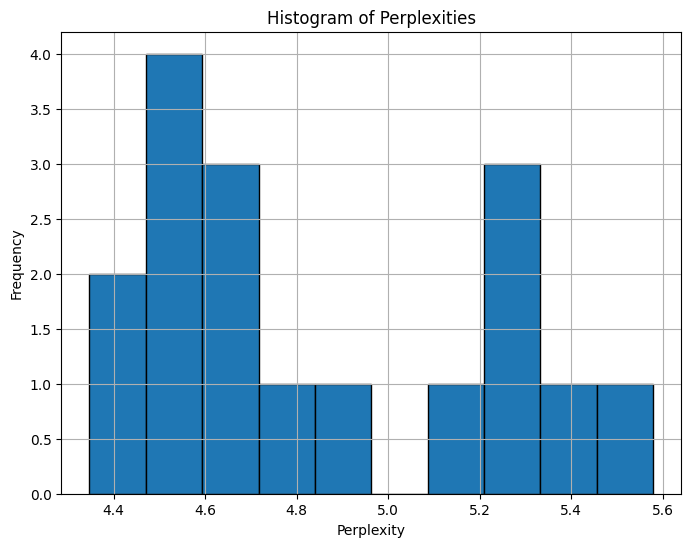

In [166]:
filtered_per = [value for value in pr if value > 75]

plt.figure(figsize=(8, 6))
plt.hist(np.log(np.array(filtered_per)), bins=10, edgecolor='black')  # Adjust 'bins' as needed
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.title('Histogram of Perplexities')
plt.grid(True)
plt.show()

In [106]:
ds[189]['gopher_verdict']

'few_words'

In [92]:
ppl

tensor(107.8683, device='mps:0')

In [102]:
import evaluate
perplexity = evaluate.load("perplexity", module_type="metric")

results = perplexity.compute(model_id="EleutherAI/pythia-160m-deduped",
                             add_start_token=False,
                             predictions=ds[:3]['text'])

  0%|          | 0/1 [00:00<?, ?it/s]